In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



### For loadaing the downloaded data, visualizing the data in tables, and applying statistical methods such as mean and standard deviation: pandas

### For graph visualizations of all kinds: matplotlib.pyplot and seaborn

In [44]:
ch4 = pd.read_csv('data/ch4_annmean_gl.csv')
co2 = pd.read_csv('data/co2_annmean_mlo.csv')
temp = pd.read_csv('data/global_temp_anomaly.csv')

In [45]:
ch4 = ch4[['year', 'mean']]
ch4.columns = ['year', 'ch4']
ch4.head()

,year,ch4
0,1984,1644.84
1,1985,1657.29
2,1986,1670.09
3,1987,1682.70
4,1988,1693.21


In [46]:
co2 = co2[co2['year'] >= 1984].reset_index(drop=True)[['year', 'mean']]
co2.columns = ['year', 'co2']
co2.head()

,year,co2
0,1984,344.87
1,1985,346.35
2,1986,347.61
3,1987,349.31
4,1988,351.69


In [47]:
temp = temp[temp['Year'] >= 1984].reset_index(drop=True)
temp.columns = ['year', 'temp_anomaly']
temp.head()

,year,temp_anomaly
0,1984,0.21
1,1985,0.17
2,1986,0.20
3,1987,0.31
4,1988,0.41


In [48]:
merged = (temp.merge(co2, on='year', how='left')
          .merge(ch4, on='year', how='left'))
merged = merged[merged['year'] < 2025].reset_index(drop=True)
merged

,year,temp_anomaly,co2,ch4
0,1984,0.21,344.87,1644.84
1,1985,0.17,346.35,1657.29
2,1986,0.20,347.61,1670.09
3,1987,0.31,349.31,1682.70
4,1988,0.41,351.69,1693.21
5,1989,0.33,353.20,1704.53
6,1990,0.36,354.45,1714.47
7,1991,0.42,355.70,1724.76
8,1992,0.11,356.54,1735.48
9,1993,0.18,357.21,1736.48


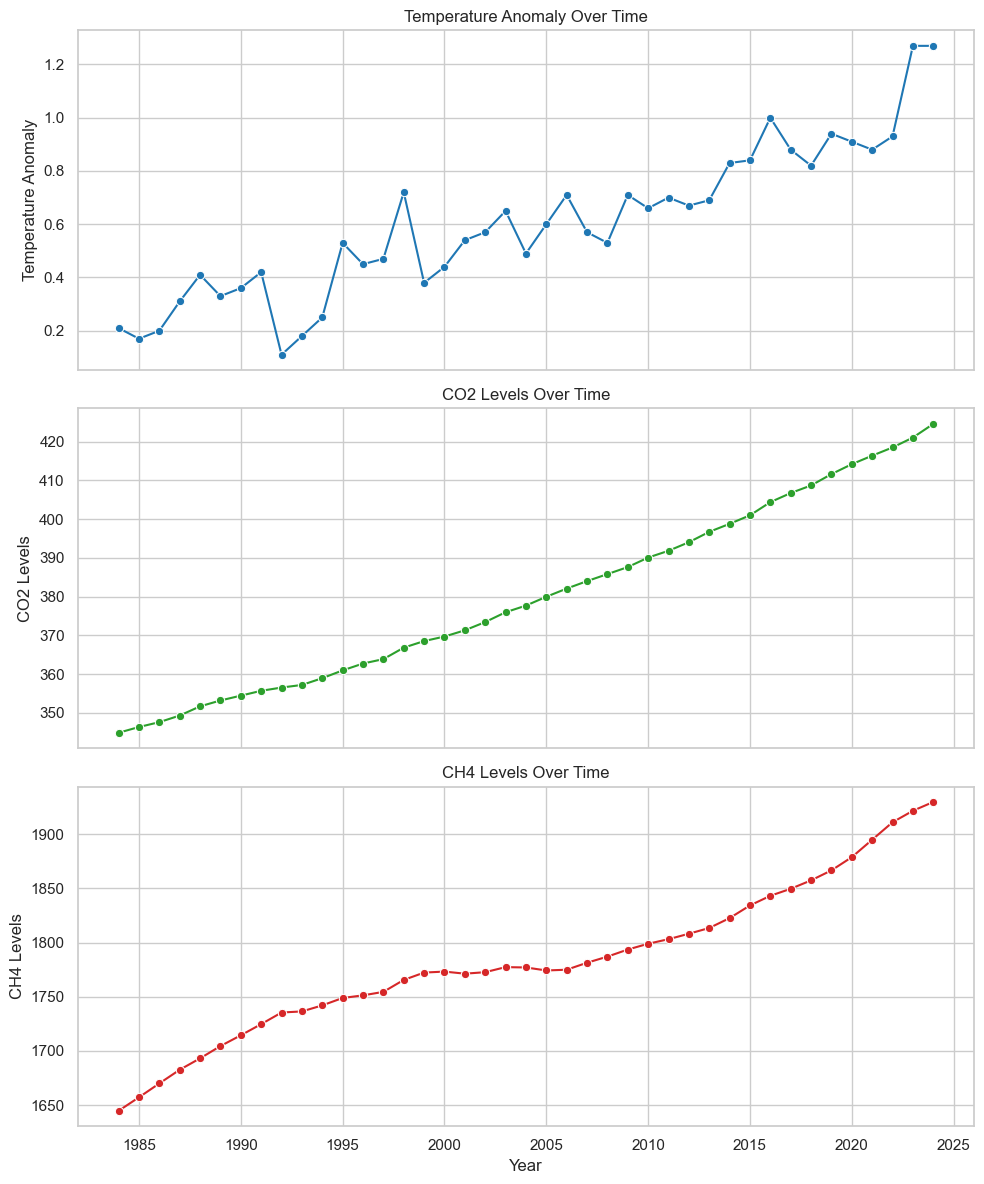

In [52]:
import seaborn as sns
sns.set(style='whitegrid')

fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

sns.lineplot(ax=axes[0], data=merged, x='year', y='temp_anomaly', marker='o', color='#1f77b4')
axes[0].set_title('Temperature Anomaly Over Time')
axes[0].set_ylabel('Temperature Anomaly')


sns.lineplot(ax=axes[1], data=merged, x='year', y='co2', marker='o', color='#2ca02c')
axes[1].set_title('CO2 Levels Over Time')
axes[1].set_ylabel('CO2 Levels')


sns.lineplot(ax=axes[2], data=merged, x='year', y='ch4', marker='o', color='#d62728')
axes[2].set_title('CH4 Levels Over Time')
axes[2].set_ylabel('CH4 Levels')
axes[2].set_xlabel('Year')

plt.tight_layout()
plt.show()

In [53]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import numpy as np

analysis_df = merged
# Use rows with complete data
if analysis_df.empty:
	print('No overlapping years across all variables. Correlations/regressions skipped.')
else:
	# Correlations
	corr_art_prev = analysis_df[['co2', 'temp_anomaly']].corr(method='pearson').iloc[0,1]
	corr_art_deaths = analysis_df[['ch4', 'temp_anomaly']].corr(method='pearson').iloc[0,1]
	print(f"Pearson r (Temperature Anomaly vs CO2): {corr_art_prev:.3f}")
	print(f"Pearson r (Temperature Anomaly vs CH4): {corr_art_deaths:.3f}")

	# Prepare X and y for models
	X = analysis_df[['co2']].values.astype(float)
	y_prev = analysis_df['temp_anomaly'].values.astype(float)
	y_deaths = analysis_df['ch4'].values.astype(float)

	def fit_and_compare_models(X, y, label):
		# Linear
		lin = LinearRegression().fit(X, y)
		yhat_lin = lin.predict(X)
		r2_lin = r2_score(y, yhat_lin)

		# Logarithmic (y ~ a + b*ln(X)), need X>0
		mask_pos = (X.flatten() > 0)
		if mask_pos.sum() >= 2:
			X_log = np.log(X[mask_pos])
			y_log = y[mask_pos]
			lin_log = LinearRegression().fit(X_log, y_log)
			yhat_log = lin_log.predict(X_log)
			r2_log = r2_score(y_log, yhat_log)
		else:
			r2_log = np.nan

		# Exponential (ln(y) ~ a + b*X), need y>0
		mask_ypos = (y > 0)
		if mask_ypos.sum() >= 2:
			lin_exp = LinearRegression().fit(X[mask_ypos], np.log(y[mask_ypos]))
			yhat_exp = np.exp(lin_exp.predict(X))
			r2_exp = r2_score(y[mask_ypos], yhat_exp[mask_ypos])
		else:
			r2_exp = np.nan

		# Quadratic
		pf = PolynomialFeatures(degree=2, include_bias=False)
		X_quad = pf.fit_transform(X)
		lin_quad = LinearRegression().fit(X_quad, y)
		yhat_quad = lin_quad.predict(X_quad)
		r2_quad = r2_score(y, yhat_quad)

		print(f"\nR^2 for {label}:")
		print(f"  Linear:       {r2_lin:.3f}")
		print(f"  Logarithmic:  {r2_log if not np.isnan(r2_log) else 'NA'}")
		print(f"  Exponential:  {r2_exp if not np.isnan(r2_exp) else 'NA'}")
		print(f"  Quadratic:    {r2_quad:.3f}")

	fit_and_compare_models(X, y_prev, 'Temperature Anomaly vs CO2')
	fit_and_compare_models(X, y_deaths, 'Temperature Anomaly vs CH4')


Pearson r (Temperature Anomaly vs CO2): 0.930
Pearson r (Temperature Anomaly vs CH4): 0.918

R^2 for Temperature Anomaly vs CO2:
  Linear:       0.864
  Logarithmic:  0.8611964973660706
  Exponential:  0.8302453224529055
  Quadratic:    0.866

R^2 for Temperature Anomaly vs CH4:
  Linear:       0.948
  Logarithmic:  0.9475855714668932
  Exponential:  0.9480230876298509
  Quadratic:    0.948


In [54]:
# Diagnostics — Overfitting checks for model forms (temp_anomaly ~ co2 + ch4)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

# Helper metrics
def compute_metrics(y_true, y_pred, num_predictors):
	"""Return dict with R2, adjR2, AIC, BIC, RSS, DW."""
	y_true = np.asarray(y_true, dtype=float)
	y_pred = np.asarray(y_pred, dtype=float)
	n = y_true.shape[0]
	if n < max(3, num_predictors + 2):
		return {
			'R2': np.nan,
			'adjR2': np.nan,
			'AIC': np.nan,
			'BIC': np.nan,
			'RSS': np.nan,
			'DW': np.nan,
		}
	res = y_true - y_pred
	RSS = float(np.sum(res**2))
	R2 = float(r2_score(y_true, y_pred))
	k = num_predictors + 1  # include intercept
	adjR2 = float(1 - (1 - R2) * (n - 1) / (n - k)) if (n - k) > 0 else np.nan
	# Gaussian likelihood approximation
	sigma2 = RSS / n
	AIC = float(n * np.log(sigma2) + 2 * k) if sigma2 > 0 else np.nan
	BIC = float(n * np.log(sigma2) + k * np.log(n)) if sigma2 > 0 else np.nan
	# Durbin–Watson for autocorrelation in residuals (sequence assumed chronological)
	DW = float(np.sum(np.diff(res)**2) / np.sum(res**2)) if np.sum(res**2) > 0 and len(res) > 1 else np.nan
	return {'R2': R2, 'adjR2': adjR2, 'AIC': AIC, 'BIC': BIC, 'RSS': RSS, 'DW': DW}

# Cross-validation with forward-chaining
def tscv_r2_scores(X, y, model_kind, max_splits=5):
	X = np.asarray(X, dtype=float)
	y = np.asarray(y, dtype=float)
	n = len(y)
	n_splits = int(min(max_splits, max(2, n - 2)))
	if n_splits < 2:
		return np.nan, np.nan
	ts = TimeSeriesSplit(n_splits=n_splits)
	scores = []
	for train_idx, test_idx in ts.split(X):
		X_tr, X_te = X[train_idx], X[test_idx]
		y_tr, y_te = y[train_idx], y[test_idx]
		if model_kind == 'linear':
			m = LinearRegression().fit(X_tr, y_tr)
			yhat = m.predict(X_te)
			scores.append(r2_score(y_te, yhat))
		elif model_kind == 'log':
			mask_tr = (X_tr > 0).all(axis=1)
			mask_te = (X_te > 0).all(axis=1)
			if mask_tr.sum() < 2 or mask_te.sum() < 1:
				continue
			m = LinearRegression().fit(np.log(X_tr[mask_tr]), y_tr[mask_tr])
			yhat = m.predict(np.log(X_te[mask_te]))
			scores.append(r2_score(y_te[mask_te], yhat))
		elif model_kind == 'exp':
			mask_tr = y_tr > 0
			mask_te = y_te > 0
			if mask_tr.sum() < 2 or mask_te.sum() < 1:
				continue
			m = LinearRegression().fit(X_tr[mask_tr], np.log(y_tr[mask_tr]))
			yhat = np.exp(m.predict(X_te[mask_te]))
			scores.append(r2_score(y_te[mask_te], yhat))
		elif model_kind == 'quad':
			pf = PolynomialFeatures(degree=2, include_bias=False)
			X_trq = pf.fit_transform(X_tr)
			X_teq = pf.transform(X_te)
			m = LinearRegression().fit(X_trq, y_tr)
			yhat = m.predict(X_teq)
			scores.append(r2_score(y_te, yhat))
		else:
			continue
	if len(scores) == 0:
		return np.nan, np.nan
	return float(np.nanmean(scores)), float(np.nanstd(scores))

# Run diagnostics for temperature outcome with two predictors (co2, ch4)
if analysis_df.empty:
	print('Diagnostics skipped: analysis_df is empty.')
else:
	results = []
	# Prepare data
	df = analysis_df.sort_values('year').reset_index(drop=True)
	X = df[['co2', 'ch4']].values.astype(float)
	y = df['temp_anomaly'].values.astype(float)

	# Linear (multiple regression)
	lin = LinearRegression().fit(X, y)
	yhat_lin = lin.predict(X)
	n_pred_lin = X.shape[1]
	m_lin = compute_metrics(y, yhat_lin, num_predictors=n_pred_lin)
	cv_lin_mean, cv_lin_std = tscv_r2_scores(X, y, 'linear')
	results.append({'Outcome': 'temp_anomaly', 'Model': 'Linear', **m_lin, 'CV_R2_mean': cv_lin_mean, 'CV_R2_sd': cv_lin_std})

	# Logarithmic on predictors (all X > 0)
	mask_pos = (X > 0).all(axis=1)
	if mask_pos.sum() >= 3:
		X_log = np.log(X[mask_pos])
		y_log = y[mask_pos]
		logm = LinearRegression().fit(X_log, y_log)
		yhat_log = logm.predict(X_log)
		m_log = compute_metrics(y_log, yhat_log, num_predictors=n_pred_lin)
		cv_log_mean, cv_log_std = tscv_r2_scores(X, y, 'log')
		results.append({'Outcome': 'temp_anomaly', 'Model': 'Logarithmic (X)', **m_log, 'CV_R2_mean': cv_log_mean, 'CV_R2_sd': cv_log_std})
	else:
		results.append({'Outcome': 'temp_anomaly', 'Model': 'Logarithmic (X)', 'R2': np.nan, 'adjR2': np.nan, 'AIC': np.nan, 'BIC': np.nan, 'RSS': np.nan, 'DW': np.nan, 'CV_R2_mean': np.nan, 'CV_R2_sd': np.nan})

	# Exponential on y (requires y > 0)
	mask_ypos = (y > 0)
	if mask_ypos.sum() >= 3:
		expm = LinearRegression().fit(X[mask_ypos], np.log(y[mask_ypos]))
		yhat_exp = np.exp(expm.predict(X[mask_ypos]))
		m_exp = compute_metrics(y[mask_ypos], yhat_exp, num_predictors=n_pred_lin)
		cv_exp_mean, cv_exp_std = tscv_r2_scores(X, y, 'exp')
		results.append({'Outcome': 'temp_anomaly', 'Model': 'Exponential (y)', **m_exp, 'CV_R2_mean': cv_exp_mean, 'CV_R2_sd': cv_exp_std})
	else:
		results.append({'Outcome': 'temp_anomaly', 'Model': 'Exponential (y)', 'R2': np.nan, 'adjR2': np.nan, 'AIC': np.nan, 'BIC': np.nan, 'RSS': np.nan, 'DW': np.nan, 'CV_R2_mean': np.nan, 'CV_R2_sd': np.nan})

	# Quadratic (degree=2 for co2, ch4)
	pf = PolynomialFeatures(degree=2, include_bias=False)
	X_quad = pf.fit_transform(X)
	quad = LinearRegression().fit(X_quad, y)
	yhat_quad = quad.predict(X_quad)
	n_pred_quad = X_quad.shape[1]
	m_quad = compute_metrics(y, yhat_quad, num_predictors=n_pred_quad)
	cv_quad_mean, cv_quad_std = tscv_r2_scores(X, y, 'quad')
	results.append({'Outcome': 'temp_anomaly', 'Model': 'Quadratic', **m_quad, 'CV_R2_mean': cv_quad_mean, 'CV_R2_sd': cv_quad_std})

	res_df = pd.DataFrame(results)
	# Order columns for readability
	cols = ['Outcome', 'Model', 'R2', 'adjR2', 'AIC', 'BIC', 'RSS', 'DW', 'CV_R2_mean', 'CV_R2_sd']
	res_df = res_df[cols]
	print('Model diagnostics (lower AIC/BIC better; DW≈2 implies low autocorrelation):')
	display(res_df)


Model diagnostics (lower AIC/BIC better; DW≈2 implies low autocorrelation):


,Outcome,Model,R2,adjR2,AIC,BIC,RSS,DW,CV_R2_mean,CV_R2_sd
0,temp_anomaly,Linear,0.867203,0.860214,-181.067775,-175.927059,0.427818,1.608702,-2.977207,2.915212
1,temp_anomaly,Logarithmic (X),0.864194,0.857046,-180.148951,-175.008235,0.437514,1.574004,-2.578666,2.512708
2,temp_anomaly,Exponential (y),0.827765,0.818701,-170.406284,-165.265567,0.554871,1.230742,-122.338836,169.223267
3,temp_anomaly,Quadratic,0.881015,0.864017,-179.570403,-169.288971,0.383323,1.761130,-279.100829,262.817044


In [ ]:
# Simple analysis 1 — Lagged predictors (0–5 years)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	max_lag = 15
	records = []
	for lag in range(0, max_lag + 1):
		lagged = df.copy()
		lagged['co2_lag'] = lagged['co2'].shift(lag)
		lagged['ch4_lag'] = lagged['ch4'].shift(lag)
		lagged = lagged.dropna().reset_index(drop=True)
		X = lagged[['co2_lag', 'ch4_lag']].values.astype(float)
		y = lagged['temp_anomaly'].values.astype(float)
		m = LinearRegression().fit(X, y)
		yhat = m.predict(X)
		R2 = float(r2_score(y, yhat))
		n = len(y)
		k = X.shape[1] + 1
		adjR2 = float(1 - (1 - R2) * (n - 1) / (n - k)) if (n - k) > 0 else np.nan
		records.append({'lag_years': lag, 'R2': R2, 'adjR2': adjR2})
	lag_df = pd.DataFrame(records)
	print('R2/adjR2 by lag (years):')
	display(lag_df)


R2/adjR2 by lag (years):


,lag_years,R2,adjR2
0,0,0.867203,0.860214
1,1,0.853080,0.845138
2,2,0.842296,0.833535
3,3,0.831655,0.822036
4,4,0.822699,0.812269
5,5,0.829540,0.819209
6,6,0.833930,0.823551
7,7,0.837628,0.827152
8,8,0.842399,0.831892
9,9,0.818280,0.805748


In [57]:
# Simple analysis 2 — Year-to-year changes (differences)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	work = df[['year', 'temp_anomaly', 'co2', 'ch4']].copy()
	work['dtemp'] = work['temp_anomaly'].diff()
	work['dco2'] = work['co2'].diff()
	work['dch4'] = work['ch4'].diff()
	work = work.dropna().reset_index(drop=True)
	X = work[['dco2', 'dch4']].values.astype(float)
	y = work['dtemp'].values.astype(float)
	m = LinearRegression().fit(X, y)
	yhat = m.predict(X)
	R2 = float(r2_score(y, yhat))
	n = len(y)
	k = X.shape[1] + 1
	adjR2 = float(1 - (1 - R2) * (n - 1) / (n - k)) if (n - k) > 0 else np.nan
	print('Model: Δtemp ~ Δco2 + Δch4')
	print(f'R2:    {R2:.3f}')
	print(f'adjR2: {adjR2:.3f}')
	coefs = pd.Series({'intercept': float(m.intercept_), 'beta_dco2': float(m.coef_[0]), 'beta_dch4': float(m.coef_[1])})
	print('Coefficients (per unit change):')
	display(coefs)


Model: Δtemp ~ Δco2 + Δch4
R2:    0.103
adjR2: 0.055
Coefficients (per unit change):


intercept   -0.104505
beta_dco2    0.068946
beta_dch4   -0.000904
dtype: float64

In [58]:
# Simple analysis 3 — Single vs. two predictors (levels)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	y = df['temp_anomaly'].values.astype(float)

	records = []
	coeffs = {}
	for label, cols in [
		('CO2 only', ['co2']),
		('CH4 only', ['ch4']),
		('CO2 + CH4', ['co2', 'ch4']),
	]:
		X = df[cols].values.astype(float)
		m = LinearRegression().fit(X, y)
		yhat = m.predict(X)
		R2 = float(r2_score(y, yhat))
		n = len(y)
		k = X.shape[1] + 1
		adjR2 = float(1 - (1 - R2) * (n - 1) / (n - k)) if (n - k) > 0 else np.nan
		records.append({'Model': label, 'R2': R2, 'adjR2': adjR2})
		coeffs[label] = {'intercept': float(m.intercept_), **{f'beta_{c}': float(coef) for c, coef in zip(cols, m.coef_)}}

	comp_df = pd.DataFrame(records)
	print('R2 and adjusted R2 by predictor set:')
	display(comp_df)
	print('Coefficients for each model:')
	display(pd.DataFrame(coeffs).T)


R2 and adjusted R2 by predictor set:


,Model,R2,adjR2
0,CO2 only,0.864006,0.860519
1,CH4 only,0.842642,0.838607
2,CO2 + CH4,0.867203,0.860214


Coefficients for each model:


,intercept,beta_co2,beta_ch4
CO2 only,-3.625496,0.011116,NaN
CH4 only,-6.039167,NaN,0.003723
CO2 + CH4,-4.321917,0.008226,0.001007


Train size: 33, Test size: 8
Test R2 (last 20%): 0.497


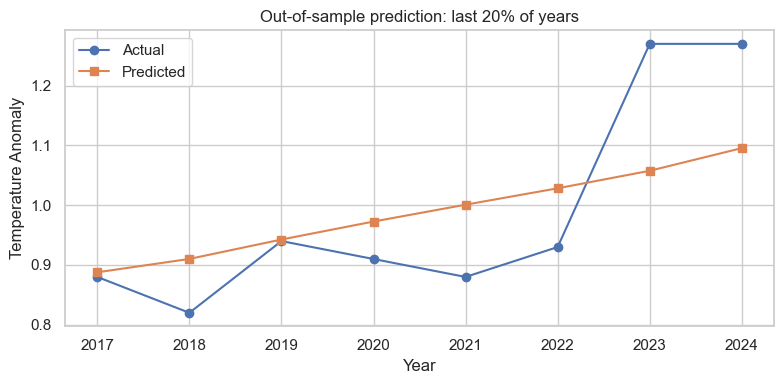

In [59]:
# Simple analysis 4 — Out-of-sample test (last 20% as test)
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	n = len(df)
	test_size = max(1, int(round(0.20 * n)))
	split = n - test_size
	X_train = df.loc[:split-1, ['co2', 'ch4']].values.astype(float)
	y_train = df.loc[:split-1, 'temp_anomaly'].values.astype(float)
	X_test = df.loc[split:, ['co2', 'ch4']].values.astype(float)
	y_test = df.loc[split:, 'temp_anomaly'].values.astype(float)
	years_test = df.loc[split:, 'year'].values

	model = LinearRegression().fit(X_train, y_train)
	yhat_test = model.predict(X_test)
	test_R2 = float(r2_score(y_test, yhat_test))
	print(f'Train size: {len(y_train)}, Test size: {len(y_test)}')
	print(f'Test R2 (last 20%): {test_R2:.3f}')

	plt.figure(figsize=(8, 4))
	plt.plot(years_test, y_test, label='Actual', marker='o')
	plt.plot(years_test, yhat_test, label='Predicted', marker='s')
	plt.title('Out-of-sample prediction: last 20% of years')
	plt.xlabel('Year')
	plt.ylabel('Temperature Anomaly')
	plt.legend()
	plt.tight_layout()
	plt.show()


Durbin–Watson statistic: 1.609 (≈2 suggests low autocorrelation)


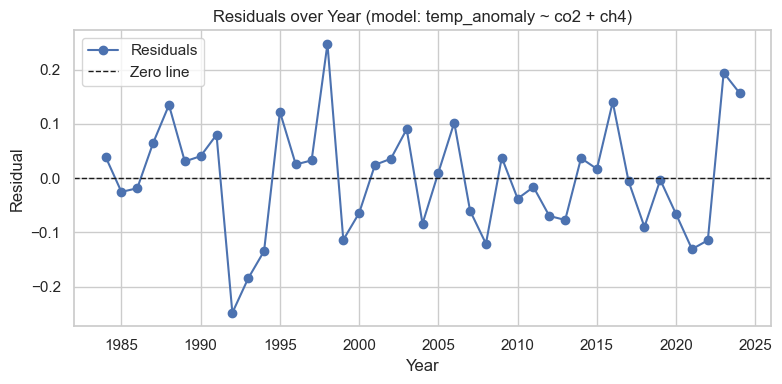

In [60]:
# Simple analysis 5 — Residuals vs Year and Durbin–Watson
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	X = df[['co2', 'ch4']].values.astype(float)
	y = df['temp_anomaly'].values.astype(float)
	model = LinearRegression().fit(X, y)
	yhat = model.predict(X)
	res = y - yhat
	DW = float(np.sum(np.diff(res)**2) / np.sum(res**2)) if np.sum(res**2) > 0 and len(res) > 1 else np.nan
	print(f'Durbin–Watson statistic: {DW:.3f} (≈2 suggests low autocorrelation)')

	plt.figure(figsize=(8, 4))
	plt.plot(df['year'].values, res, marker='o', linestyle='-', label='Residuals')
	plt.axhline(0, color='k', linewidth=1, linestyle='--', label='Zero line')
	plt.title('Residuals over Year (model: temp_anomaly ~ co2 + ch4)')
	plt.xlabel('Year')
	plt.ylabel('Residual')
	plt.legend()
	plt.tight_layout()
	plt.show()


In [61]:
# Simple analysis 6 — Slope interpretation in real units
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	X = df[['co2', 'ch4']].values.astype(float)
	y = df['temp_anomaly'].values.astype(float)
	model = LinearRegression().fit(X, y)
	b_co2, b_ch4 = [float(v) for v in model.coef_]
	b0 = float(model.intercept_)

	per_10ppm_co2 = 10.0 * b_co2
	per_100ppb_ch4 = 100.0 * b_ch4

	print('Linear model: temp_anomaly = b0 + b_co2*CO2 + b_ch4*CH4')
	print(f'b0 (intercept): {b0:.4f} °C')
	print(f'b_co2 (per 1 ppm CO2): {b_co2:.6f} °C/ppm')
	print(f'b_ch4 (per 1 ppb CH4): {b_ch4:.6f} °C/ppb')
	print('\nInterpretation (scaled to easy units):')
	print(f'• A +10 ppm increase in CO2 is associated with about {per_10ppm_co2:.4f} °C higher temperature anomaly (holding CH4 fixed).')
	print(f'• A +100 ppb increase in CH4 is associated with about {per_100ppb_ch4:.4f} °C higher temperature anomaly (holding CO2 fixed).')


Linear model: temp_anomaly = b0 + b_co2*CO2 + b_ch4*CH4
b0 (intercept): -4.3219 °C
b_co2 (per 1 ppm CO2): 0.008226 °C/ppm
b_ch4 (per 1 ppb CH4): 0.001007 °C/ppb

Interpretation (scaled to easy units):
• A +10 ppm increase in CO2 is associated with about 0.0823 °C higher temperature anomaly (holding CH4 fixed).
• A +100 ppb increase in CH4 is associated with about 0.1007 °C higher temperature anomaly (holding CO2 fixed).


In [62]:
# Simple analysis 7 — 5-year rolling averages regression
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()
	win = 5
	sm = pd.DataFrame({'year': df['year']})
	sm['temp_ma5'] = df['temp_anomaly'].rolling(window=win).mean()
	sm['co2_ma5'] = df['co2'].rolling(window=win).mean()
	sm['ch4_ma5'] = df['ch4'].rolling(window=win).mean()
	sm = sm.dropna().reset_index(drop=True)
	X = sm[['co2_ma5', 'ch4_ma5']].values.astype(float)
	y = sm['temp_ma5'].values.astype(float)
	m = LinearRegression().fit(X, y)
	yhat = m.predict(X)
	R2 = float(r2_score(y, yhat))
	n = len(y)
	k = X.shape[1] + 1
	adjR2 = float(1 - (1 - R2) * (n - 1) / (n - k)) if (n - k) > 0 else np.nan
	print('Model on 5-year rolling means: temp_ma5 ~ co2_ma5 + ch4_ma5')
	print(f'R2:    {R2:.3f}')
	print(f'adjR2: {adjR2:.3f}')


Model on 5-year rolling means: temp_ma5 ~ co2_ma5 + ch4_ma5
R2:    0.969
adjR2: 0.967


Pearson r (CO2 vs CH4): 0.974


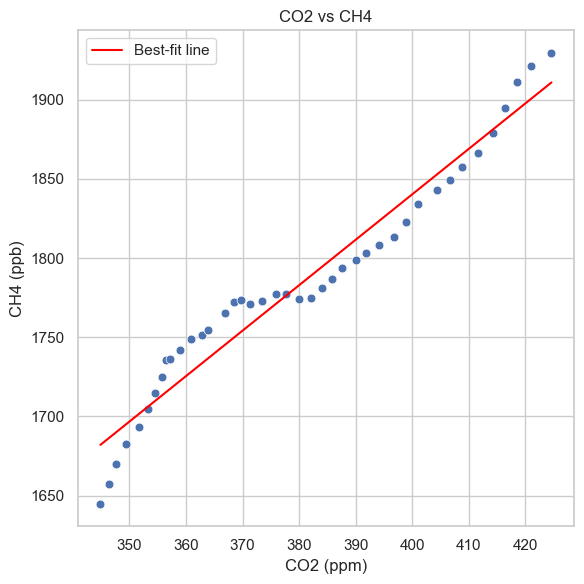

In [ ]:
# Simple analysis 8 — CO2 vs CH4 collinearity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

if analysis_df.empty:
	print('Skipped: analysis_df is empty.')
else:
	df = analysis_df.sort_values('year').reset_index(drop=True).copy()


	r = float(df[['co2', 'ch4']].corr(method='pearson').iloc[0,1])


	print(f'Pearson r (CO2 vs CH4): {r:.3f}')
	plt.figure(figsize=(6, 6))
	sns.scatterplot(data=df, x='co2', y='ch4', s=40)
	z = np.polyfit(df['co2'].values.astype(float), df['ch4'].values.astype(float), 1)
	xline = np.linspace(df['co2'].min(), df['co2'].max(), 100)
	yline = z[0] * xline + z[1]
	plt.plot(xline, yline, color='red', label='Best-fit line')
	plt.title('CO2 vs CH4')
	plt.xlabel('CO2 (ppm)')
	plt.ylabel('CH4 (ppb)')
	plt.legend()
	plt.tight_layout()
	plt.show()
